In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



2 2
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded explosion and earthquake dataset:
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (20507, 0.4987)  |  explosion: (20616, 0.5013)  
Val ds:
earthquake: (255, 0.0762)  |  explosion: (3092, 0.9238)  
Test ds:
earthquake: (176, 0.0789)  |  explosion: (2055, 0.9211)  


In [3]:
model_type = "CNN_baseline"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = False
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()

Fitting noise set time augmentor: [--------------------------------------->] 100 %

Fit process completed after 119.68094253540039 seconds. Total datapoints fitted: 21199.
Average time per datapoint: 0.005645593779678305


Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 155.85465002059937 seconds. Total datapoints fitted: 41123.
Average time per datapoint: 0.0037899630382170406


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 21.17845344543457 seconds. Total datapoints fitted: 3347.
Average time per datapoint: 0.006327592902729181


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 14.592644691467285 seconds. Total datapoints fitted: 2231.
Average time per datapoint: 0.006540853738891656


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validatio

['20210429-183612']
Trying to create result file
Made result file:  results_CNN_baseline_earthExplo_timeAug_standard_unbalanced_valtest_subsample-0.25_numChannels-3_f3.csv
[   {'model_type': 'CNN_baseline'},
    {   'batch_size': 128,
        'cnn_activation': 'relu',
        'dense_activation': 'relu',
        'epochs': 50,
        'learning_rate': 0.01,
        'optimizer': 'sgd',
        'output_layer_activation': 'sigmoid'}]
Saving file. 1 rows.
results_CNN_baseline_earthExplo_timeAug_standard_unbalanced_valtest_subsample-0.25_numChannels-3_f3.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6000, 16)          400       
____________

- val_f3: 0.0
Epoch 25/50
321/321 [==============================] - 2s 7ms/step - loss: 0.6931 - precision: 0.9740 - recall: 0.0111 - binary_accuracy: 0.5048 - val_loss: 0.6904 - val_precision: 0.8846 - val_recall: 1.0954e-08 - val_binary_accuracy: 0.9228
- val_f3: 0.0
Epoch 26/50
321/321 [==============================] - 2s 7ms/step - loss: 0.6931 - precision: 0.8606 - recall: 0.1281 - binary_accuracy: 0.5104 - val_loss: 0.6907 - val_precision: 0.8654 - val_recall: 0.0038 - val_binary_accuracy: 0.9228
- val_f3: 0.0044
Epoch 27/50
321/321 [==============================] - 2s 7ms/step - loss: 0.6930 - precision: 0.7136 - recall: 0.4832 - binary_accuracy: 0.5080 - val_loss: 0.6866 - val_precision: 1.0000 - val_recall: 1.0954e-08 - val_binary_accuracy: 0.9237
- val_f3: 0.0
Epoch 28/50
321/321 [==============================] - 2s 7ms/step - loss: 0.6930 - precision: 0.9769 - recall: 0.0038 - binary_accuracy: 0.5054 - val_loss: 0.6889 - val_precision: 0.9231 - val_recall: 1.0954e-08 - v

20541 57 20143 347
['explosion', 'earthquake']
EE


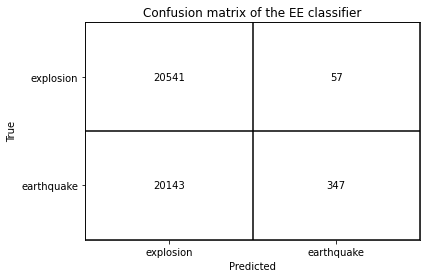

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[20541,    57],
       [20143,   347]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.50      1.00      0.67     20598
  earthquake       0.86      0.02      0.03     20490

    accuracy                           0.51     41088
   macro avg       0.68      0.51      0.35     41088
weighted avg       0.68      0.51      0.35     41088

Unsaved val eval:
3066 8 253 1
['explosion', 'earthquake']
EE


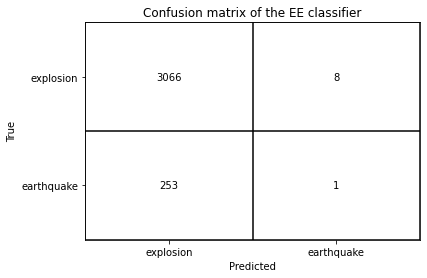

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3066,    8],
       [ 253,    1]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.92      1.00      0.96      3074
  earthquake       0.11      0.00      0.01       254

    accuracy                           0.92      3328
   macro avg       0.52      0.50      0.48      3328
weighted avg       0.86      0.92      0.89      3328

Unsaved test eval:
1999 10 164 3
['explosion', 'earthquake']
EE


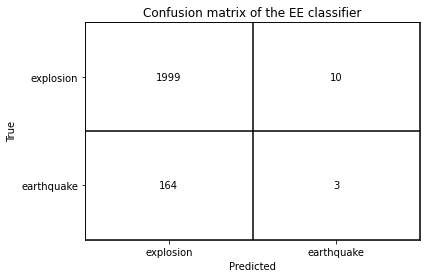

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1999,   10],
       [ 164,    3]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.92      1.00      0.96      2009
  earthquake       0.23      0.02      0.03       167

    accuracy                           0.92      2176
   macro avg       0.58      0.51      0.50      2176
weighted avg       0.87      0.92      0.89      2176



In [8]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = False
start_from_scratch = False
use_reduced_lr = False
log_data = True

beta = 3

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModelRam(noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, 
                              start_from_scratch = start_from_scratch, beta = beta)
params = {
        "batch_size" : 128,
        "epochs" : 50,
        "learning_rate" : 0.01,
        "optimizer" : "sgd",
        "cnn_activation" : "relu",
        "dense_activation" : "relu",
        "output_layer_activation" : "sigmoid"
    }
model = modelTrain.run(x_train, y_train, x_val, y_val, x_test, y_test, 16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

3061 13 251 3


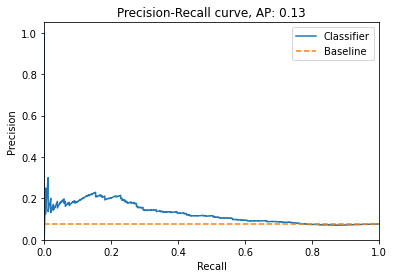

['explosion', 'earthquake']
EE


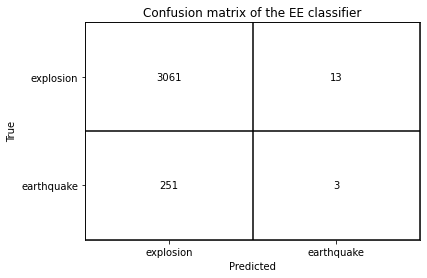

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3061,   13],
       [ 251,    3]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.92      1.00      0.96      3074
  earthquake       0.19      0.01      0.02       254

    accuracy                           0.92      3328
   macro avg       0.56      0.50      0.49      3328
weighted avg       0.87      0.92      0.89      3328



In [5]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [6]:
accuracy, precision, recall, fscore

(0.92067307692307687, 0.1875, 0.011811, 0.022221999999999999)

In [7]:
import matplotlib as plt
plt.plotconfusion(y_val, 2)

AttributeError: module 'matplotlib' has no attribute 'plotconfusion'

# 